In [47]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "svg"

In [83]:
from time import sleep
from typing import Optional
from urllib.parse import quote

import requests


def inspire_query_hits(query: str, subject: Optional[str] = None) -> int:
    URL = f"https://inspirehep.net/api/literature?size=1&q={quote(query)}"
    if subject is not None:
        URL += f"&subject={quote(subject)}"
    res = requests.get(URL)
    if res.status_code == 429:
        wait_ms = float(res.headers["X-Retry-In"].replace("ms", ""))
        sleep(wait_ms * 1e-3)
        return inspire_query_hits(query, subject)
    res.raise_for_status()
    d = res.json()
    try:
        return d["hits"]["total"]
    except KeyError:
        return 0

In [89]:
%%time

YEARS = range(2005, 2021)

DISCIPLINES = [
    "Experiment-HEP",
    "Phenomenology-HEP",
    "Astrophysics",
]

LANGS = [
    "python",
#    "C++",
    "Fortran",
    "Mathematica",
    "IDL",
]

data = {
    disc: pd.DataFrame({
        lang: {
            year: inspire_query_hits(query=f"{lang} and date={year}", subject=disc)
            for year in YEARS
        }
        for lang in LANGS
    })
    for disc in DISCIPLINES
}

CPU times: user 7.35 s, sys: 283 ms, total: 7.63 s
Wall time: 1min 34s


2005      4
2006     12
2007     13
2008     34
2009     34
2010     49
2011     52
2012     83
2013     75
2014     51
2015     56
2016     66
2017     92
2018    100
2019     99
2020    114
dtype: int64

In [ ]:
df_fixed

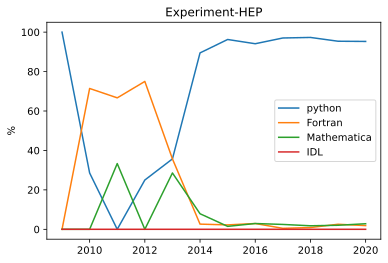

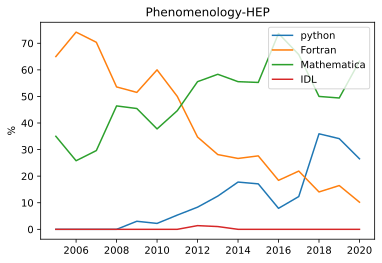

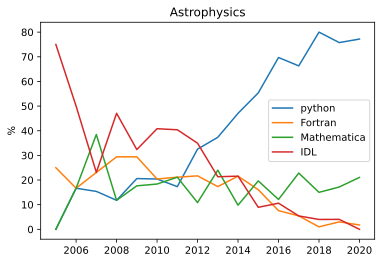

In [118]:
for disc in DISCIPLINES:
    df_fixed = data[disc].copy()
    df_fixed.loc[2020] = df_fixed.loc[2020] * 2
    df_fixed = 100 * df_fixed.div(df_fixed.sum(axis=1), axis=0)
    
    plt.title(disc)
    df_fixed.plot(ax=plt.gca())
    plt.ylabel("%")
    plt.savefig(f"Lang_{disc}.svg", bbox_inches="tight")
    plt.show()